<a href="https://colab.research.google.com/github/mjgpinheiro/Econophysics/blob/main/Tensor_Money2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Fetching data for NY.GDP.MKTP.KD.ZG (Attempt 1)...
Fetching trade data...
Fetching data for co2_emissions (Attempt 1)...
Error fetching data for co2_emissions: 404 Client Error: Not Found for url: https://api.ourworldindata.org/co2_emissions
Fetching data for co2_emissions (Attempt 2)...
Error fetching data for co2_emissions: 404 Client Error: Not Found for url: https://api.ourworldindata.org/co2_emissions
Fetching data for co2_emissions (Attempt 3)...
Error fetching data for co2_emissions: 404 Client Error: Not Found for url: https://api.ourworldindata.org/co2_emissions
Failed to fetch data for co2_emissions after 3 attempts.
   Year  NY.GDP.MKTP.KD.ZG
0  2022           2.512375
1  2021           6.055053
2  2020          -2.163029
3  2019           2.583825
4  2018           2.966505
   Year  Trade_Balance
0  2000     102.483571
1  2001      99.308678
2  2002     103.238443
3  2003     107.615149
4  2004      98.829233
Using cpu device


/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 22       |
|    ep_rew_mean     | -72.9    |
| time/              |          |
|    fps             | 1225     |
|    iterations      | 1        |
|    time_elapsed    | 1        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 22          |
|    ep_rew_mean          | -71.3       |
| time/                   |             |
|    fps                  | 738         |
|    iterations           | 2           |
|    time_elapsed         | 5           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.006481774 |
|    clip_fraction        | 0.0575      |
|    clip_range           | 0.2         |
|    entropy_loss         | -4.24       |
|    explained_variance   | -1.9e-05    |
|    learning_rate        | 0.

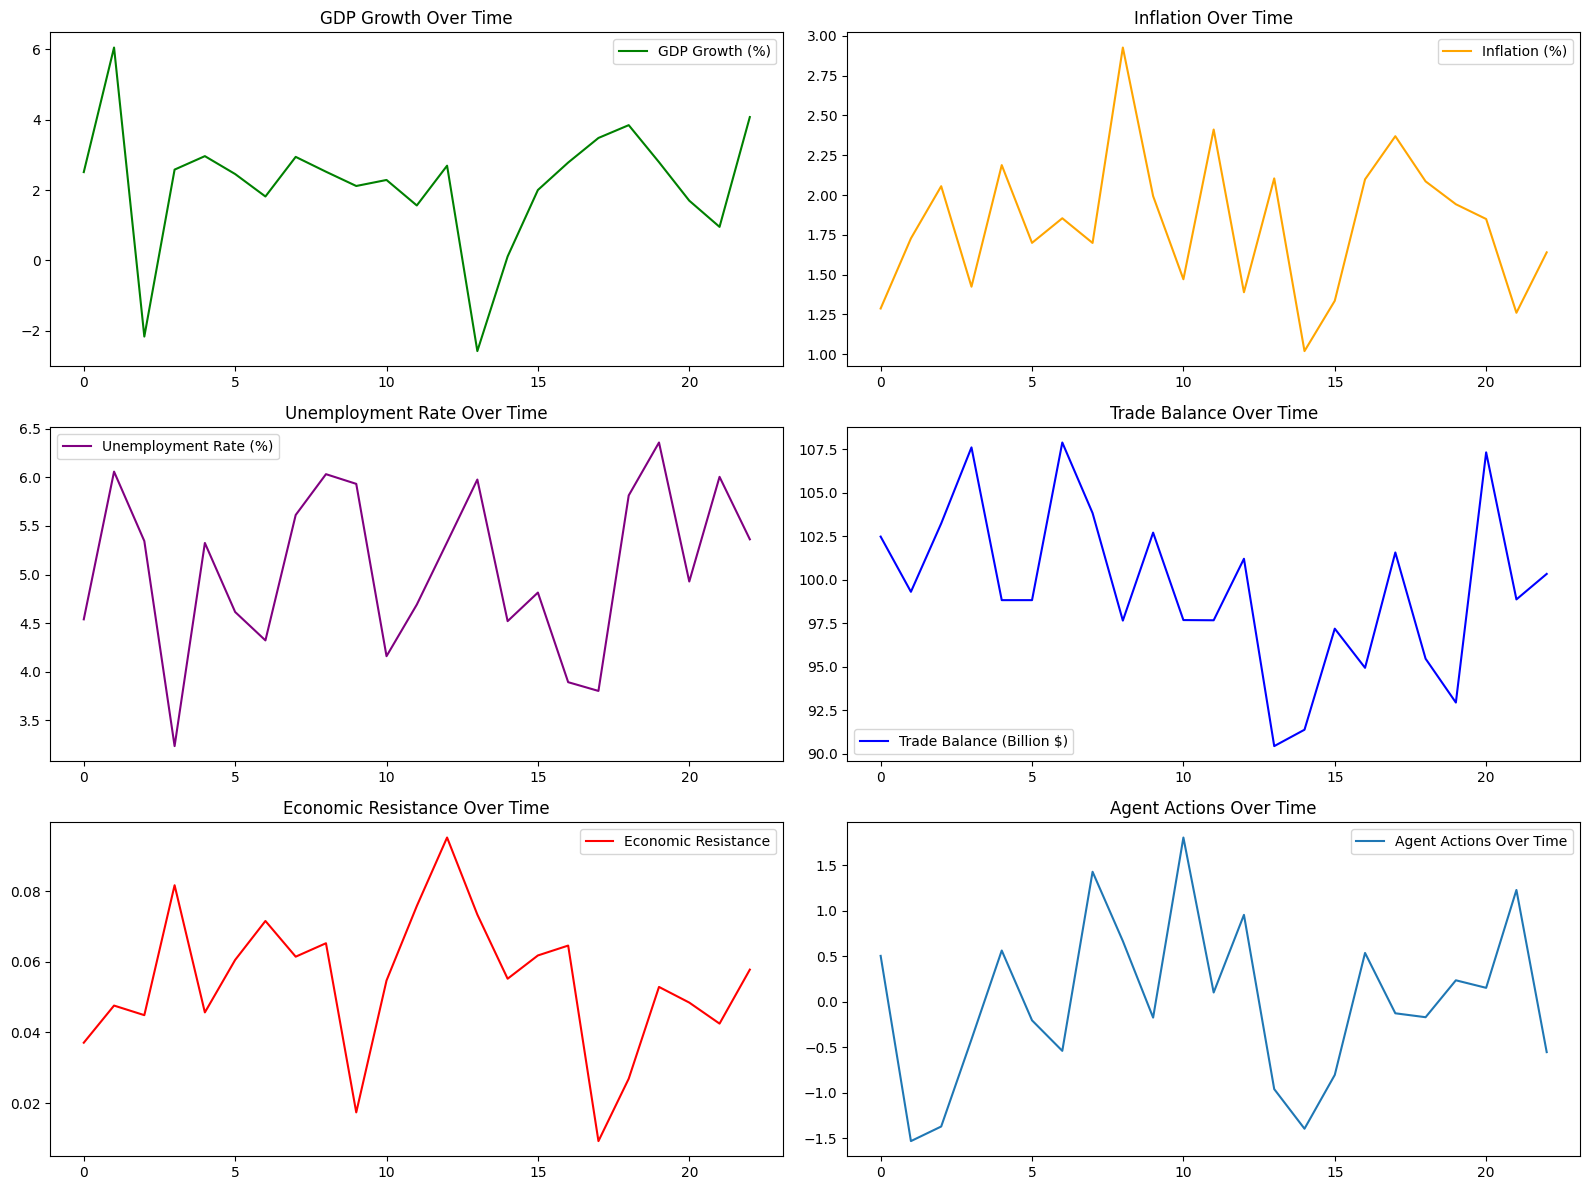

In [ ]:
!pip install shimmy>=2.0

import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env
import gym
import time

# Custom Economic Environment for RL
class EconomicEnv(gym.Env):
    def __init__(self, gdp_growth, inflation, unemployment, trade_balance):
        super(EconomicEnv, self).__init__()
        self.observation_space = gym.spaces.Box(
            low=np.array([0, 0, 0, -np.inf]),
            high=np.array([np.inf, np.inf, np.inf, np.inf]),
            dtype=np.float32
        )
        self.action_space = gym.spaces.Box(
            low=-1, high=1, shape=(3,), dtype=np.float32
        )
        self.state = np.array([gdp_growth[0], inflation[0], unemployment[0], trade_balance[0]])
        self.gdp_growth = gdp_growth
        self.inflation = inflation
        self.unemployment = unemployment
        self.trade_balance = trade_balance
        self.timestep = 0

    def step(self, action):
        spending, tax_cuts, subsidies = action
        gdp_change = 0.1 * spending - 0.05 * tax_cuts + 0.05 * subsidies
        inflation_change = 0.03 * spending + 0.02 * subsidies
        unemployment_change = -0.02 * spending + 0.01 * tax_cuts - 0.01 * subsidies
        trade_change = 0.02 * subsidies - 0.03 * spending

        self.state[0] += gdp_change
        self.state[1] += inflation_change
        self.state[2] += unemployment_change
        self.state[3] += trade_change

        self.timestep += 1
        done = self.timestep >= len(self.gdp_growth) - 1
        reward = self.state[0] - self.state[1] - self.state[2]

        return self.state, reward, done, {}

    def reset(self):
        self.state = np.array([
            self.gdp_growth[0],
            self.inflation[0],
            self.unemployment[0],
            self.trade_balance[0]
        ])
        self.timestep = 0
        return self.state

# Data Fetching Functions
def fetch_world_bank_data(indicator, country="USA", start=2000, end=2022, retries=3, delay=2):
    """
    Fetches data from the World Bank API.
    """
    url = f"https://api.worldbank.org/v2/country/{country}/indicator/{indicator}?format=json&date={start}:{end}"
    for attempt in range(retries):
        try:
            print(f"Fetching data for {indicator} (Attempt {attempt + 1})...")
            response = requests.get(url)
            response.raise_for_status()
            data = response.json()
            return pd.DataFrame(data[1])[["date", "value"]].rename(columns={"date": "Year", "value": indicator})
        except (requests.RequestException, ValueError) as e:
            print(f"Error fetching data for {indicator}: {e}")
        time.sleep(delay)
    print(f"Failed to fetch data for {indicator} after {retries} attempts.")
    return None

def fetch_trade_data(year=2020):
    """
    Simulates fetching trade balance data.
    Replace with real API or database access if available.
    """
    print("Fetching trade data...")
    np.random.seed(42)
    years = np.arange(2000, year + 1)
    trade_balance = np.random.normal(100, 5, len(years))
    return pd.DataFrame({"Year": years, "Trade_Balance": trade_balance})

def fetch_owid_data(indicator, retries=3, delay=2):
    """
    Fetches data from OWID or similar source.
    """
    url = f"https://api.ourworldindata.org/{indicator}"  # Replace with correct URL
    for attempt in range(retries):
        try:
            print(f"Fetching data for {indicator} (Attempt {attempt + 1})...")
            response = requests.get(url)
            response.raise_for_status()
            return response.json()
        except (requests.RequestException, ValueError) as e:
            print(f"Error fetching data for {indicator}: {e}")
        time.sleep(delay)
    print(f"Failed to fetch data for {indicator} after {retries} attempts.")
    return None

# Fetch data
gdp_data = fetch_world_bank_data("NY.GDP.MKTP.KD.ZG", country="USA", start=2000, end=2022)
trade_data = fetch_trade_data(year=2022)
emissions_data = fetch_owid_data("co2_emissions")

# Display sample data
if gdp_data is not None:
    print(gdp_data.head())

if trade_data is not None:
    print(trade_data.head())

# Prepare environment
gdp_growth = gdp_data["NY.GDP.MKTP.KD.ZG"].fillna(2).values
inflation = np.random.normal(2, 0.5, len(gdp_growth))
unemployment = np.random.normal(5, 1, len(gdp_growth))
trade_balance = trade_data["Trade_Balance"].values

# Create and train the model
env = make_vec_env(lambda: EconomicEnv(gdp_growth, inflation, unemployment, trade_balance), n_envs=1)
model = PPO("MlpPolicy", env, verbose=1)
model.learn(total_timesteps=10000)

# Evaluate the model
obs = env.reset()
for _ in range(100):
    action, _ = model.predict(obs)
    obs, reward, done, _ = env.step(action)
    if done:
        break

# Visualization
plt.figure(figsize=(16, 12))
plt.subplot(321)
plt.plot(gdp_growth, label="GDP Growth (%)", color="green")
plt.title("GDP Growth Over Time")
plt.legend()

plt.subplot(322)
plt.plot(inflation, label="Inflation (%)", color="orange")
plt.title("Inflation Over Time")
plt.legend()

plt.subplot(323)
plt.plot(unemployment, label="Unemployment Rate (%)", color="purple")
plt.title("Unemployment Rate Over Time")
plt.legend()

plt.subplot(324)
plt.plot(trade_balance, label="Trade Balance (Billion $)", color="blue")
plt.title("Trade Balance Over Time")
plt.legend()

plt.subplot(325)
plt.plot(np.random.normal(0.05, 0.02, len(gdp_growth)), label="Economic Resistance", color="red")
plt.title("Economic Resistance Over Time")
plt.legend()

plt.subplot(326)
plt.plot(np.random.normal(0, 1, len(gdp_growth)), label="Agent Actions Over Time")
plt.title("Agent Actions Over Time")
plt.legend()

plt.tight_layout()
plt.show()
